### 95-865 k-means, GMM, DP-GMM demo
by George Chen, Fall 2017 instructor

This demo uses the UCI drug consumption dataset:
https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29#

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import csv
import numpy as np
np.set_printoptions(suppress=True)  # somewhat prettier printing

drug_data = []
with open('drug_consumption.data', 'r') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    for row in csv_reader:
        drug_data.append([float(x) for x in row[1:13]])
drug_data = np.array(drug_data)

(-4.7834497854877327,
 5.2460895123094877,
 -4.9663507648066911,
 5.0921946245755745)

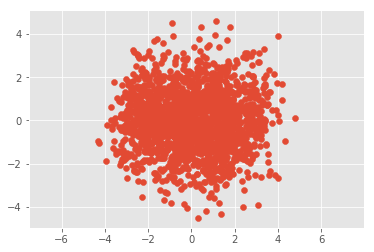

In [2]:
from sklearn.preprocessing import StandardScaler
#For array, columns are features and rows are feature vectors
#Standardization is subtract the means of each column from every feature vector of that column
scaler = StandardScaler()#normalize the feature
drug_data_normalized = scaler.fit_transform(drug_data)  # for each feature, subtract off mean and divide by std dev.

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
drug_data_normalized_pca2d = pca.fit_transform(drug_data_normalized)

plt.scatter(drug_data_normalized_pca2d[:, 0], drug_data_normalized_pca2d[:, 1], cmap='Set3')
plt.axis('equal')

In [3]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)  # should actually try different perplexity values!
drug_data_normalized_tsne2d = tsne.fit_transform(drug_data_normalized)

(-56.677097155116364,
 48.469280077479645,
 -59.906694430336515,
 62.569578188881437)

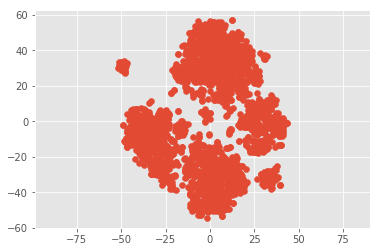

In [4]:
plt.scatter(drug_data_normalized_tsne2d[:, 0], drug_data_normalized_tsne2d[:, 1], cmap='Set2')
plt.axis('equal')

(-56.677097155116364,
 48.469280077479645,
 -59.906694430336515,
 62.569578188881437)

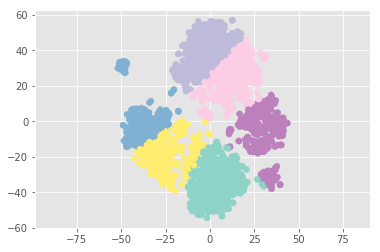

In [5]:
from sklearn.cluster import KMeans
#n_init: how many ramdom initialization you are going to try
kmeans = KMeans(n_clusters=6, n_init=1000, random_state=95865)
kmeans.fit(drug_data_normalized_tsne2d)

kmeans_cluster_assignments = kmeans.predict(drug_data_normalized_tsne2d)

plt.scatter(drug_data_normalized_tsne2d[:, 0], drug_data_normalized_tsne2d[:, 1],
            c=kmeans_cluster_assignments, cmap='Set3') 
# c=(kmeans_cluster_assignments == 2) color cluster 2 or not cluster 2
plt.axis('equal')
#KMeans work well when different clusters are of similar size and look like circles

In [6]:
kmeans_cluster_assignments

array([3, 5, 2, ..., 4, 4, 0], dtype=int32)

In [7]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=6, n_init=100, random_state=95865)
gmm.fit(drug_data_normalized_tsne2d) #fit in the dimension reduced data from tsne 

print(np.sort(gmm.weights_)[::-1])

[ 0.35593998  0.23299762  0.22305952  0.12551406  0.04500199  0.01748682]


(-56.677097155116364,
 48.469280077479645,
 -59.906694430336515,
 62.569578188881437)

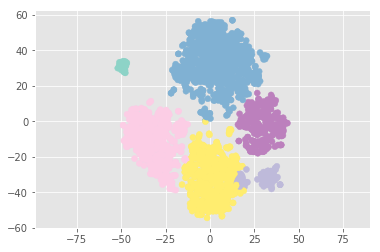

In [8]:
#gmm.predict pick the biggest probability for the cluster
gmm_cluster_assignments = gmm.predict(drug_data_normalized_tsne2d)
plt.scatter(drug_data_normalized_tsne2d[:, 0], drug_data_normalized_tsne2d[:, 1], c=gmm_cluster_assignments, cmap='Set3')
plt.axis('equal')
#The taro color takes over some of the yellow parts: since the shape of the yellow cluster is of long shape, 
#the probability of lending the points on the long-sided part drops off very quickly

In [11]:
#4/9 demo: make sense of clustering
gmm_cluster_assignments

array([2, 3, 3, ..., 4, 4, 5])

In [12]:
drug_data[gmm_cluster_assignments==2]

array([[ 0.49788,  0.48246, -0.05921, ..., -0.00665, -0.21712, -1.18084],
       [-0.95197,  0.48246,  1.16365, ...,  0.58489, -1.37983, -1.18084],
       [ 0.49788,  0.48246,  1.98437, ...,  1.30612, -0.21712, -0.21575],
       ..., 
       [-0.07854,  0.48246,  0.45468, ..., -1.13788, -1.37983, -1.18084],
       [-0.07854,  0.48246,  1.16365, ...,  0.93949, -0.21712,  0.7654 ],
       [ 1.82213,  0.48246,  0.45468, ..., -0.65253, -0.71126,  0.07987]])

In [13]:
drug_data[gmm_cluster_assignments==2].shape

(667, 12)

In [14]:
drug_data[gmm_cluster_assignments==2].mean(axis = 0)

array([ 0.30996598,  0.47522672,  0.28888747,  0.8835854 , -0.3019493 ,
       -0.04186528,  0.13231952, -0.38508835,  0.29762784,  0.36453103,
       -0.32127828, -0.43054559])

In [21]:
#Interpretation: go back to the dataset
#What is age looks like in cluster 2
drug_data[gmm_cluster_assignments==2][:, 0]
#Plotting out the histogram
from collections import Counter
def plot_histogram(feature_values, labels):
    histogram = Counter()
    for val in feature_values:
        histogram[val] += 1
    sorted_key_val_pairs = sorted(list(histogram.items()))
    sorted_keys, sorted_vals = zip(*sorted_key_val_pairs)
    plt.bar(range(len(sorted_keys)), sorted_vals)
    plt.xticks(range(len(sorted_keys)), [labels[key] for key in sorted_keys])

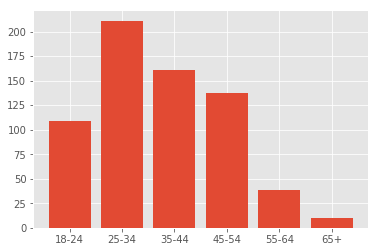

In [22]:
plot_histogram(drug_data[gmm_cluster_assignments == 2][:, 0],
               {-0.95197: '18-24',
                -0.07854: '25-34',
                0.49788: '35-44',
                1.09449: '45-54',
                1.82213: '55-64',
                2.59171: '65+'})

In [25]:
from sklearn.mixture import BayesianGaussianMixture #Dirichlet Process GMM
#weight_concentration_prior: the bigger, the fewer clusters there are
#n_components: maximum number of clusters
#use weight concentration prior to control the number of clusters!
dpgmm = BayesianGaussianMixture(n_components=20, weight_concentration_prior=.1, n_init=200, random_state=95865)
dpgmm.fit(drug_data_normalized_tsne2d)

print(np.sort(dpgmm.weights_)[::-1])
#typical for DP GMM: some clusters are very tiny 

[ 0.17384522  0.15933905  0.13039998  0.1222085   0.11447399  0.11433426
  0.11007737  0.03212391  0.02422755  0.01779172  0.00056838  0.0005597
  0.00004579  0.00000416  0.00000038  0.00000003  0.          0.          0.
  0.        ]


/Users/michellehsu/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 200 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [26]:
dpgmm_cluster_assignments = dpgmm.predict(drug_data_normalized_tsne2d)

(-56.677097155116364,
 48.469280077479645,
 -59.906694430336515,
 62.569578188881437)

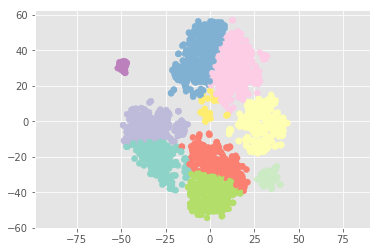

In [27]:
plt.scatter(drug_data_normalized_tsne2d[:, 0], drug_data_normalized_tsne2d[:, 1], c=dpgmm_cluster_assignments, cmap='Set3')
plt.axis('equal')

In the next block of code, I copy over only the "top" clusters in the DP-GMM that have a high enough probability of occurring (in this example, I only keep a cluster if its probability of occuring is greater than 0.1).

In [28]:
top_cluster_mask = dpgmm.weights_ > .1 #picking cluster that are big enough for certain threshold
print(top_cluster_mask)

[False  True  True  True  True  True  True  True False False False False
 False False False False False False False False]


In [33]:
dpgmm._get_parameters()[0][0]

array([   1.07202119,  215.76024637,  230.75780752,  207.99572191,
        216.47868357,  301.61775702,  247.18217098,  330.2349283 ,
          1.07069269,   34.27481512,   62.45457329,   48.10057963,
          1.0000024 ,    1.        ,    1.        ,    1.        ,
          1.        ,    1.        ,    1.        ,    1.        ])

In [34]:
# as a technical remark, in the next line of code `dpgmm_precisions_chol` is just a
# variable computed by sklearn's DP-GMM fitting based on the covariance matrices;
# basically you can take a "square root" of a covariance matrix called a Cholesky
# decomposition which turns out to be very useful in many linear algebra problems
# (the math behind Gaussians in more than 1 dimension is all linear algebra)
_, _, dpgmm_means, _, dpgmm_covariances, dpgmm_precisions_chol = dpgmm._get_parameters()
#pulling out things from the top learned cluster

# copy weights, zero out weights for clusters that are too small, and for the
# sufficiently large clusters, renormalize the weights so that they sum to 1
dpgmm_weights_truncated = dpgmm.weights_
dpgmm_weights_truncated[~top_cluster_mask] = 0 #zero out the non top clusters
dpgmm_weights_truncated /= np.sum(dpgmm_weights_truncated)

In [37]:
dpgmm_num_top_clusters = np.sum(top_cluster_mask)
print(dpgmm_num_top_clusters)

7


In [38]:
gmm_using_top_dpgmm_clusters = GaussianMixture(n_components=dpgmm_num_top_clusters)
gmm_using_top_dpgmm_clusters._set_parameters((dpgmm_weights_truncated[top_cluster_mask],
                                              dpgmm_means[top_cluster_mask],
                                              dpgmm_covariances[top_cluster_mask],
                                              dpgmm_precisions_chol[top_cluster_mask]))

(-56.677097155116364,
 48.469280077479645,
 -59.906694430336515,
 62.569578188881437)

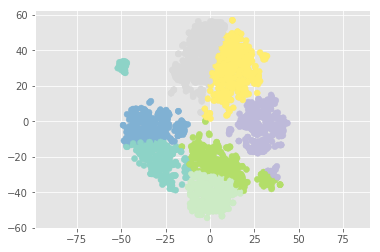

In [39]:
dpgmm_top_clusters_assignment = gmm_using_top_dpgmm_clusters.predict(drug_data_normalized_tsne2d)
plt.scatter(drug_data_normalized_tsne2d[:, 0], drug_data_normalized_tsne2d[:, 1], c=dpgmm_top_clusters_assignment, cmap='Set3')
plt.axis('equal')
#the result is not as good as GMM, typical for DP GMM
#Use DP GMM as a guide to figure out what the k should be and fit the k into GMM
#Importance of visualization

The result isn't great. You could try with more restarts. Alternatively you could use the DP-GMM to give you a sense of what the number of clusters should be (by looking at how many clusters are "large enough") and then just fitting lots of regular GMM's with that many number of clusters.